Fieldtrip: KIT oddball analysis with source localization using beamformer
=========================================================================

Lead authors: Hadi Zaatiti hadi.zaatiti@nyu.edu, Osama Abdullah, osama.abdullah@nyu.edu

This notebook is to be run in MATLAB, while having fieldtrip library installed.
It is a pipeline for processing the `oddball` experiment raw data acquired from KIT-MEG system at NYUAD, run frequency analysis in source space, source localization using Beamformer technique.
The `oddball` code experiment in Psychtoolbox can be found here:

[Oddball experiment page](https://meg-pipeline.readthedocs.io/en/latest/3-experimentdesign/experiments/6-exp-sound.html)

[Oddball PsychToolBox code for KIT system](https://github.com/hzaatiti-NYU/meg-pipeline/blob/bc99896a4e271b902282b1432c12e338060f4fa0/experiments/psychtoolbox/sound/oddball/run_oddball_KIT.m)

Importing data and preprocessing
--------------------------------
The data used in this notebook is hosted on `NYU BOX`. Permissions are given upon request.

- Install the BOX app from [here](https://www.box.com/resources/downloads)
- Set an environment variable with name `MEG_DATA` to the path of the Data folder e.g.,
    - `C:\Users\user_name\Box\MEG\Data`
    - or `C:\Users\user_name\Box\Data`

Each experiment run using the KIT system generates a `.con` and several `.mrk`. Find more details about these files in the other chapters.
In the following setup the variables pointing to your data, headshape and MRI scan.

In [1]:
% Read the environment variable to NYU BOX
MEG_DATA_FOLDER = getenv('MEG_DATA');

% Set path to KIT .con file of sub-03
DATASET_PATH = [MEG_DATA_FOLDER,'oddball\sub-03\meg-kit\sub-03-raw-kit.con'];

% Set path to computed .mat variables, these has been obtained by executing this pipeline and 
% will allow you to skip steps if you wish to execute a particular cell
LOAD_PATH = [MEG_DATA_FOLDER, 'oddball\derivatives\kit_oddball_pipeline\sub-03\'];

% Experiment your own test and save your variables in a folder of your choice, choose the folder where to save your variables
% We will also use it to copy variables from LOAD_PATH and use them in the notebook if needed
SAVE_PATH = 'docs\source\5-pipeline\notebooks\fieldtrip\fieldtrip_oddball_kit_data\';

% It is important that you use T1.mgz instead of orig.mgz as T1.mgz is normalized to [255,255,255] dimension
MRI_FILE         = fullfile([MEG_DATA_FOLDER,'oddball\sub-03\anat\sub-003\sub-003\mri\T1.mgz']);
 
laser_surf      = fullfile([MEG_DATA_FOLDER,'oddball\sub-03\anat\digitized-headshape\sub-03-basic-surface.txt']);
%The cleaned stylus points removes the last three columns (dx, dx, dz) and
%keeps only x,y,z
laser_points    = [MEG_DATA_FOLDER, 'oddball\sub-03\anat\digitized-headshape\sub-03-stylus-cleaned.txt'];
mrkfile1        = [MEG_DATA_FOLDER,'oddball\sub-03\meg-kit\240524-1.mrk'];
mrkfile2        = [MEG_DATA_FOLDER, 'oddball\sub-03\meg-kit\240524-2.mrk'];

try
    cd(SAVE_PATH)
catch
end

Read the digitized headshape and stylus points.
More information on those in other chapters of the documentation.
The `read_head_shape_laser` function can be found in `pipeline/field_trip_pipelines/matlab_functions`. You can add it to your MATLAB path.

In [2]:
lasershape   = read_head_shape_laser(laser_surf,laser_points);

shape = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []

In [3]:
lasershape   = ft_convert_units(lasershape, 'mm');

Plot initial digitized headshape.

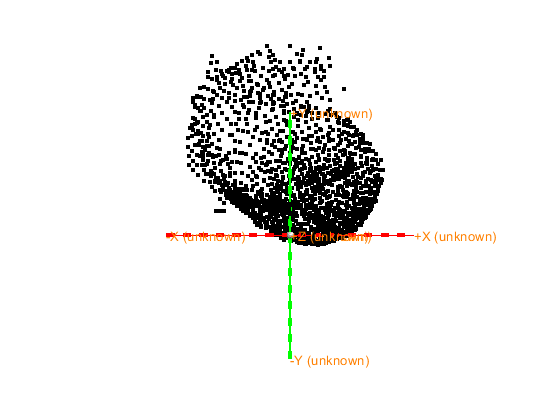

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'

In [4]:
ft_determine_coordsys(lasershape, 'interactive', 'no')

Let us now define a coordinate system for the digitized headshape based on the known fiducials from the laser_shape.
CTF is an ALS coordinate system meaning:
- the X-coordinate axis points to A (Anterior)
- the Y-coordinate axis points to L (Left)
- the Z-coordinate axis points to S (Superior)

The first, 4th and 5th fiducials in the stylus points correspond to Nasion, Left Ear and Right Ear.
More information on digitized headshape fiducials is found [here.](https://meg-pipeline.readthedocs.io/en/latest/2-operationprotocol/operationprotocol.html)
Define the transformation as follows:

In [5]:
laser2ctf = ft_headcoordinates(lasershape.fid.pos(1,:),lasershape.fid.pos(4,:),lasershape.fid.pos(5,:),'ctf');

Apply the transformation to the digitized headshape.

In [6]:
lasershape = ft_transform_geometry(laser2ctf, lasershape)

lasershape = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'

Plot to verify the new coordinate system and ensure that the new coordinate system is indeed CTF.

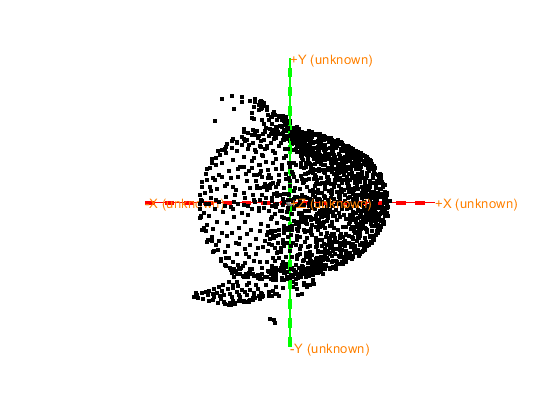

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = <a href="matlab:helpPopup('struct')" class="headerDataType">struct</a> with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'

In [7]:
ft_determine_coordsys(lasershape, 'interactive', 'no')

Apply a z-plane cut to remove unncessary points from digitized-headshape under a certain z-value.

-------------------------------------------------------------------------------------------
FieldTrip is developed by members and collaborators of the Donders Institute for Brain,
Cognition and Behaviour at Radboud University, Nijmegen, the Netherlands.

                          --------------------------
                        /                            \
                     ------------------------------------
                    /                                    \
          -------------------------------------------------
         /                            /\/\/\/\/\ 
         ---------------------------------------------------
                  |        F  i  e  l  d  T  r  i  p       |
                  ------------------------------------------
                   \                                      /
                     ------------------------------------
                          \            /
                            ----------

Please cite the FieldTrip re

ans = logical
   1

ans = logical
   1

keeping 1251 and removing 430 vertices in the mesh
the call to "ft_defacemesh" took 5 seconds


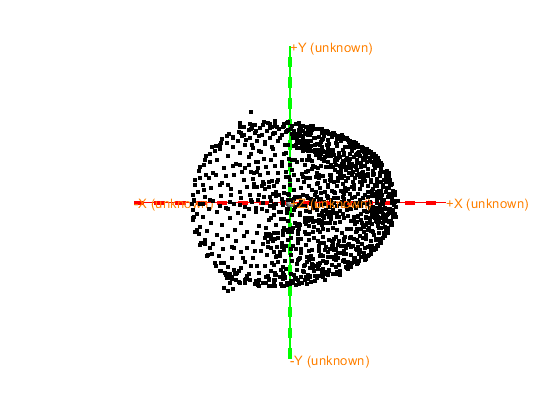

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = struct with fields:
      pos: [1251x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'
      cfg: [1x1 struct]

In [8]:
% Deface the laser mesh under a certain plan (change planecut) Define the configuration for ft_defacemesh
planecut = -5;
cfg = [];
cfg.method    = 'plane';       % Use a plane for exclusion
cfg.translate = [0 0 planecut]; % A point on the plane (adjust z_value as needed)
cfg.rotate    = [0 0 0];       % Rotation vector, modify if the plane is not axis-aligned
cfg.selection = 'outside';     % Remove points below the plane

% Apply ft_defacemesh to remove points below the plane
mesh = ft_defacemesh(cfg, lasershape);

% Plot the resulting mesh to check the results
figure
ft_determine_coordsys(mesh, 'interactive', 'no')

When you are happy with the result set your lasershape as the defaced mesh.

In [9]:
lasershape = mesh

lasershape = struct with fields:
      pos: [1251x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'
      cfg: [1x1 struct]

Read subjets MRI T1w scan.

In [10]:
%% read mri and mri-headshape
mri = ft_read_mri(MRI_FILE); % read mri file
MRI_FILE = ft_convert_units(mri, 'mm'); %make sure units mm

extracting compressed dataset to C:\Users\hz3752\AppData\Local\Temp\x2001df3da49bb0c143cbbaaf3ffbe706\...
extracted dataset is located at C:\Users\hz3752\AppData\Local\Temp\x2001df3da49bb0c143cbbaaf3ffbe706\T1


Inspect visually the MRI.

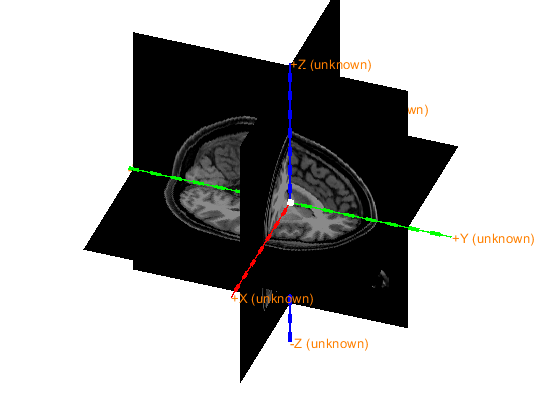

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


In [11]:
mri = ft_determine_coordsys(mri, 'interactive', 'no');

the input is volume data with dimensions [256 256 256]
voxel size along 1st dimension (i) : 1.000000 mm
voxel size along 2nd dimension (j) : 1.000000 mm
voxel size along 3rd dimension (k) : 1.000000 mm
volume per voxel                   : 1.000000 mm^3
the input is volume data with dimensions [256 256 256]
voxel size along 1st dimension (i) : 1.000000 mm
voxel size along 2nd dimension (j) : 1.000000 mm
voxel size along 3rd dimension (k) : 1.000000 mm
volume per voxel                   : 1.000000 mm^3
flipped the volume to make it consistent with the axes of the coordinate system
0. Press "h" to show this help
1. To change the slice viewed in one plane, either:
   a. click (left mouse) in the image on a different plane. Eg, to view a more
      superior slice in the horizontal plane, click on a superior position in the
      coronal plane, or
   b. use the arrow keys to increase or decrease the slice number by one
2. To mark a fiducial position or anatomical landmark, do BOTH:
   a. sel

 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_headcoordinates.m' at line 233
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 1044

the call to "ft_volumerealign" took 111 seconds


mri_init = struct with fields:
              dim: [256 256 256]
          anatomy: [256x256x256 double]
              hdr: [1x1 struct]
        transform: [4x4 double]
             unit: 'mm'
              cfg: [1x1 struct]
    transformorig: [4x4 double]
         coordsys: 'ctf'

The positive x-axis is pointing towards anterior
The positive y-axis is pointing towards the left
The positive z-axis is pointing towards superior


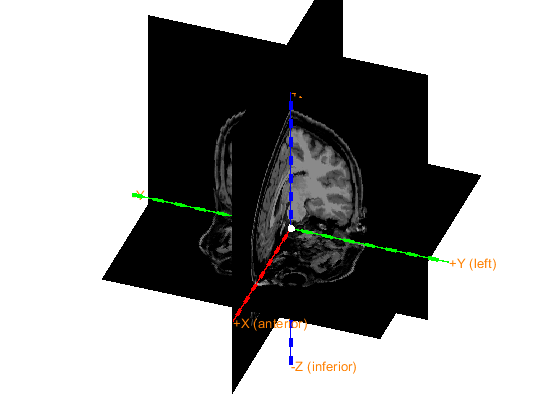

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


In [12]:
cfg             = [];
cfg.method      = 'interactive';
cfg.coordsys    = 'ctf'; %use CTF coordinates (pos x toward nose, +y to left)
mri_init = ft_volumerealign(cfg,mri)
ft_determine_coordsys(mri_init, 'interactive', 'no'); % sanity check, should be CTF

save mri_init mri_init

The MRI data is now in the CTF coordinate system (based on ALS).

In [ ]:
load mri_init mri_init

In [ ]:
Now we would like to coregister the sensors with the digitized headshape.
Each `.mrk` file holds the positions of five points obtained from HPI coils that had been placed on the participants head in specific locations.
Read more about the positions of the points in https://meg-pipeline.readthedocs.io/en/latest/2-operationprotocol/operationprotocol.html

The order in which they appear in a `.mrk` are the following:



In [50]:
%% Align MEG Dewar to Laser scan Head model
% now we want to align the 3 markers in the *.con file with the 3 markers
% in the lasershape, where 1:5 markers match to the 4:9 lasershape
% fiducials
mrk1 = ft_read_headshape(mrkfile1);
mrk1 = ft_convert_units(mrk1, lasershape.unit);
mrk2 = ft_read_headshape(mrkfile2);
mrk2 = ft_convert_units(mrk2, lasershape.unit);

The input file is an original one: only marker-coil positions are loaded
The input file is an original one: only marker-coil positions are loaded


mrk1 has been recorded prior to the experiment and mrk2 just after the end.
Compute the average positions of the five points over both time points.

In [51]:
% Define the average marker positions, mrk1 correspond to HPI coils at the
% beginning and end of the experiment
mrka = mrk1;
mrka.fid.pos = (mrk1.fid.pos+mrk2.fid.pos)/2;

In [76]:
% pcoils holds all the marker points 
p_coils = mrka.fid.pos(1:5,:);
p_headscan = lasershape.fid.pos;

Plot points

In [53]:
t1 = ft_headcoordinates(p_coils(1,:), p_coils(2,:), p_coils(3,:), 'ctf');%J p_coils(1,:) is not exactly the nasion, so do not interpret the X-axis as going through the nasion
t2 = ft_headcoordinates(p_headscan(6,:), p_headscan(4,:), p_headscan(5,:), 'ctf');%J

In [54]:
% t2\t1 is interpreted as the transformation t that, if you apply t to a
% point, then you apply t1 on the resulting point, becomes as if you
% applied t2 on that point, this means the composition t1(t(point)) = t2

transform_mrk2laser = t2\t1;
% p1t = ft_warp_apply(transform_mrk2laser, p1)

grad = ft_read_sens(DATASET_PATH,'senstype','meg');
grad = ft_convert_units(grad,'mm');
grad = ft_transform_geometry(transform_mrk2laser, grad);


save grad grad

At this point, we have coregistered the sensors locations with the digitized headshape.
We computed the transformation from sensor space to digitized headshape space knowing which points from the HPI coils should match which stylus points from the laser scan.
Then, this transformation was applied to the sensors.
As a sanity check, lets plot the sensors, headshape, HPI coils locations and the stylus points.
`ft_transform_geometry` does not allow us to apply the transformation to the HPI_coils position themselves, we will need to apply the transformation differently.
We propose two ways below

In [77]:
% Extract the first 3x3 submatrix corresponding to the rotation matrix
rotation_matrix = transform_mrk2laser(1:3, 1:3);

% Extract the translation vector corresponding to the last column and removing the last element
translation_vector = transform_mrk2laser(1:3, 4);

% Display the results
disp('Rotation matrix:');
disp(rotation_matrix);

disp('Translation vector:');
disp(translation_vector);

Rotation matrix:
    0.9602   -0.0355    0.2771
    0.0384    0.9993   -0.0051
   -0.2767    0.0155    0.9608

Translation vector:
   16.7548
   -5.3949
   42.4524



In [78]:
% Apply the transformation to the transpose of p_coils

p_coils_t = rotation_matrix*p_coils'+ translation_vector

p_coils_t = 3x5 double
  104.4093   -1.9115    1.9115   87.3524   97.7621
    4.7914   74.7645  -74.7645   41.7716  -27.7891
   21.3170   -0.5097    0.5097   24.0880   25.6129

In [82]:
% Set back the positions of the p_coils to the transformed coordinates
p_coils = p_coils_t'

p_coils = 5x3 double
  104.4093    4.7914   21.3170
   -1.9115   74.7645   -0.5097
    1.9115  -74.7645    0.5097
   87.3524   41.7716   24.0880
   97.7621  -27.7891   25.6129

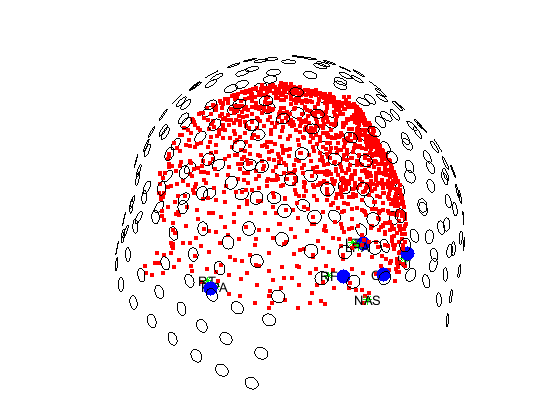

In [83]:
figure
ft_plot_headshape(lasershape)
ft_plot_sens(grad)
hold on
plot3(p_coils(:,1), p_coils(:,2), p_coils(:,3), 'bo', 'MarkerSize', 10, 'MarkerFaceColor', 'b', 'LineStyle', 'none')
%plot3(p_headscan(:,1), p_headscan(:,2), p_headscan(:,3), 'bo', 'MarkerSize', 10, 'MarkerFaceColor', 'b', 'LineStyle', 'none')
view([50 20])
hold on

In [ ]:
Another way is to use what is described here: https://www.fieldtriptoolbox.org/faq/homogenous/



In [70]:
% Assume p_coils is already defined

p_coils = mrka.fid.pos(1:5,:);

% Create a column vector of ones
num_points = size(p_coils, 1);
ones_column = ones(num_points, 1);

% Concatenate the column of ones to p_coils
p_coils_with_ones = [p_coils, ones_column];

% Transpose the resulting matrix
p_coils_transposed = p_coils_with_ones';

% Display the result
disp('Original p_coils:');
disp(p_coils);

disp('p_coils with ones added and transposed:');
disp(p_coils_transposed);

Original p_coils:
   90.4042    6.7430    3.9254
   -2.9621   80.0952  -46.8581
   -5.3097  -69.4416  -44.0606
   74.6782   44.3433    1.6745
   81.5830  -25.5108    6.3767

p_coils with ones added and transposed:
   90.4042   -2.9621   -5.3097   74.6782   81.5830
    6.7430   80.0952  -69.4416   44.3433  -25.5108
    3.9254  -46.8581  -44.0606    1.6745    6.3767
    1.0000    1.0000    1.0000    1.0000    1.0000



In [71]:
p_coils_t = transform_mrk2laser * p_coils_transposed


p_coils_t = 4x5 double
  104.4093   -1.9115    1.9115   87.3524   97.7621
    4.7914   74.7645  -74.7645   41.7716  -27.7891
   21.3170   -0.5097    0.5097   24.0880   25.6129
    1.0000    1.0000    1.0000    1.0000    1.0000

In [72]:
p_coils = p_coils_t'

p_coils = 5x4 double
  104.4093    4.7914   21.3170    1.0000
   -1.9115   74.7645   -0.5097    1.0000
    1.9115  -74.7645    0.5097    1.0000
   87.3524   41.7716   24.0880    1.0000
   97.7621  -27.7891   25.6129    1.0000

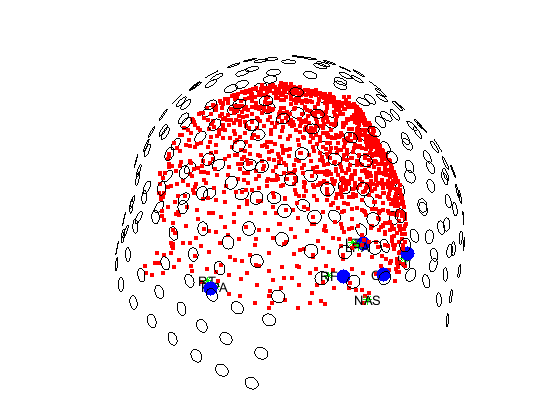

In [73]:
figure
ft_plot_headshape(lasershape)
ft_plot_sens(grad)
hold on
plot3(p_coils(:,1), p_coils(:,2), p_coils(:,3), 'bo', 'MarkerSize', 10, 'MarkerFaceColor', 'b', 'LineStyle', 'none')
%plot3(p_headscan(:,1), p_headscan(:,2), p_headscan(:,3), 'bo', 'MarkerSize', 10, 'MarkerFaceColor', 'b', 'LineStyle', 'none')
view([50 20])

In [ ]:
Let us view display the order of appearence of each label

In [ ]:
Let us measure the relative error